# Predicción de los precios de Amazon

In [19]:
# Obtenemos la data de Yahoo Finance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics

In [2]:
amzn = pd.read_csv('AMZN.csv', index_col=0)

amzn.index = pd.to_datetime(amzn.index)
amzn.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-26', '2020-05-27'],
              dtype='datetime64[ns]', name='Date', length=5132, freq=None)

In [3]:
amzn1 = amzn[['Close','Volume']].iloc[3000:]
amzn1

,Close,Volume
Date,,
2011-12-05,196.240005,5922100
2011-12-06,191.990005,5202000
2011-12-07,195.320007,6427300
2011-12-08,190.479996,4361100
2011-12-09,193.029999,5158800
...,...,...
2020-05-20,2497.939941,3998100
2020-05-21,2446.739990,5114400
2020-05-22,2436.879883,2867100


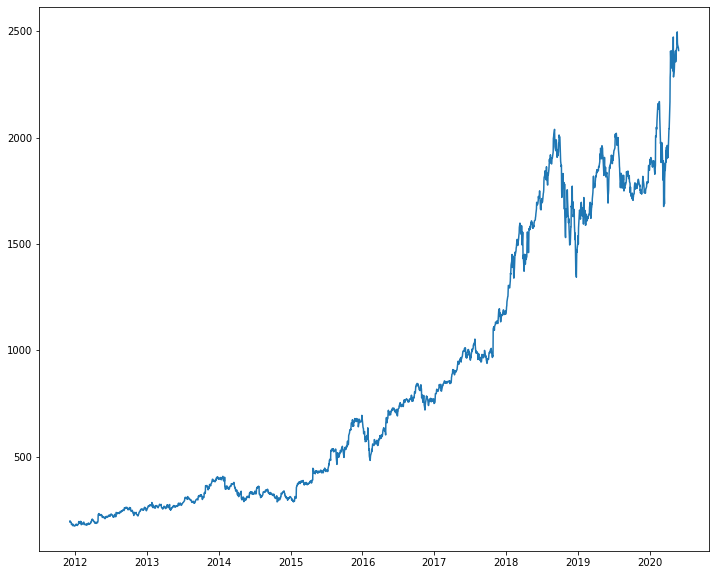

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,10))
plt.plot(amzn1.index, amzn1['Close'])
plt.show()

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
decomposition = seasonal_decompose(amzn1['Close'], period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


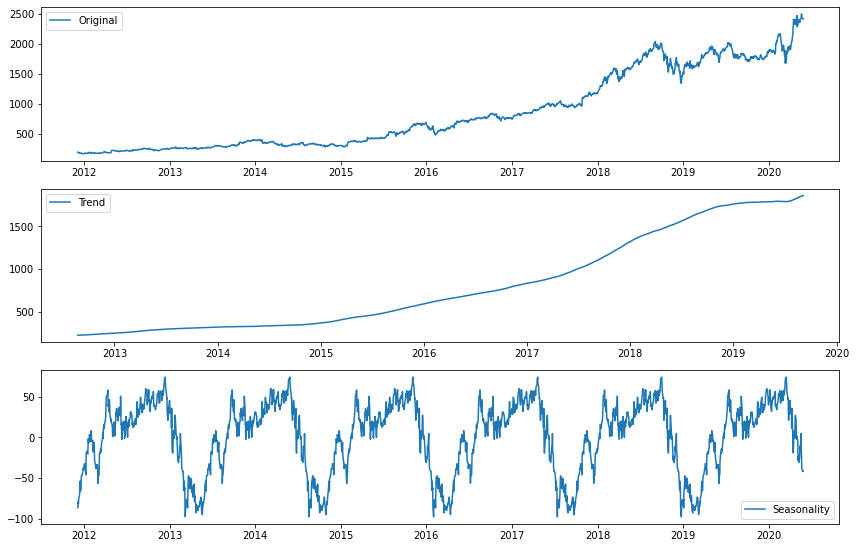

In [7]:
plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(amzn1['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
amzn1_log = np.log(amzn1['Close'])
amzn1_log.dropna(inplace=True)
s_test = adfuller(amzn1_log, autolag='AIC')
print('Log transform stationary check p value: ', s_test[1])

Log transform stationary check p value:  0.9077593649676206


Text(0, 0.5, 'First order log diff')

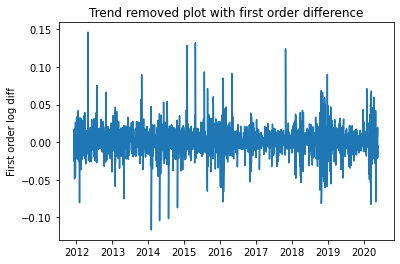

In [10]:
amzn1_log_diff = amzn1_log - amzn1_log.shift()
amzn1_log_diff.dropna(inplace=True)
plt.title('Trend removed plot with first order difference')
plt.plot(amzn1_log_diff)
plt.ylabel('First order log diff')

In [11]:
s_test = adfuller(amzn1_log_diff, autolag='AIC')
print ("First order difference stationary check p value: ", s_test[1] )

First order difference stationary check p value:  2.187162804402878e-28


In [12]:
moving_avg = amzn1_log.rolling(30).mean()

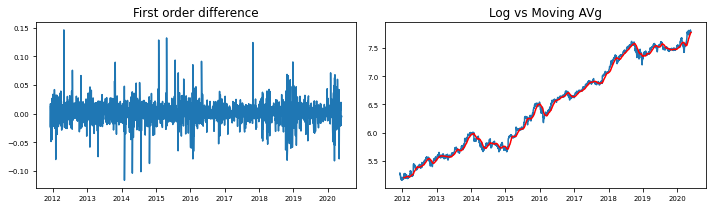

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
ax1.set_title('First order difference')
ax1.tick_params(axis='x', labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
ax1.plot(amzn1_log_diff)
ax2.plot(amzn1_log)
ax2.set_title('Log vs Moving AVg')
ax2.tick_params(axis='x', labelsize=7)
ax2.tick_params(axis='y', labelsize=7)
ax2.plot(moving_avg, color='red')
plt.tight_layout()

In [14]:
import statsmodels.api as sm


Text(0.5, 0, 'Lags')

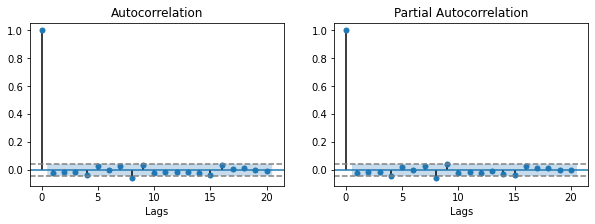

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,3))
# ACF chart
fig = sm.graphics.tsa.plot_acf(amzn1_log_diff.values.squeeze(), lags=20,ax=ax1)
# draw 95% confidence interval line
ax1.axhline(y=-1.96/np.sqrt(len(amzn1_log_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(amzn1_log_diff)),linestyle='--',color='gray')
ax1.set_xlabel('Lags')
# PACF chart
fig = sm.graphics.tsa.plot_pacf(amzn1_log_diff, lags=20, ax=ax2)
# draw 95% confidence interval line
ax2.axhline(y=-1.96/np.sqrt(len(amzn1_log_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(amzn1_log_diff)),linestyle='--',color='gray')
ax2.set_xlabel('Lags')

In [22]:
# build model
model = sm.tsa.ARIMA(amzn1_log, order=(1,0,0))
results_ARIMA = model.fit(disp=-1)
ts_predict = results_ARIMA.predict()
# Evaluate model
print("AIC: ", results_ARIMA.aic)
print("BIC: ", results_ARIMA.bic)
print("Mean Absolute Error: ", metrics.mean_squared_error(amzn1_log.values, ts_predict.values))
print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(amzn1_log.values, ts_predict.values)))
# check autocorrelation
print("Durbin-Watson statistic :", sm.stats.durbin_watson(results_ARIMA.resid.values))

AIC:  -10802.207757259886
BIC:  -10785.21330990403
Mean Absolute Error:  0.0010935364474402918
Root Mean Squared Error:  0.033068662619469384
Durbin-Watson statistic : 1.3250448669953367


/home/alvin/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
